<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity


## WIP



In [1]:
import sys
sys.path.append("../../image_classification") # to get the utilities of image classication (utils_ic)
sys.path.append("..") # to get the utilities of image similarity (utils_is)

from pathlib import Path
import pandas as pd
import pickle
import numpy as np
import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *
from torch.cuda import get_device_name
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook

from utils_ic.gpu_utils import gpu_info
from utils_ic.datasets import Urls, unzip_url
from utils_ic.imagenet_models import model_to_learner

from utils_is.metrics import compute_vector_distance

print(f"Fast.ai version = {fastai.__version__}")
print(f"Machine's GPU info = {gpu_info()} (memory unit = MiB)")
print(f"Fast.ai/Torch is using {get_device_name(0)}")

Fast.ai version = 1.0.47.post1
Machine's GPU info = [{'device_name': 'TITAN V', 'total_memory': '12035', 'used_memory': '1000'}, {'device_name': 'TITAN V', 'total_memory': '12036', 'used_memory': '12'}, {'device_name': 'TITAN V', 'total_memory': '12036', 'used_memory': '12'}] (memory unit = MiB)
Fast.ai/Torch is using TITAN V


In [2]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 5
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 244
BATCH_SIZE    = 8
ARCHITECTURE  = models.resnet18

In [3]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/home/miguel/repos/ComputerVisionBestPractices/image_classification/data/fridgeObjects/carton'),
 PosixPath('/home/miguel/repos/ComputerVisionBestPractices/image_classification/data/fridgeObjects/models'),
 PosixPath('/home/miguel/repos/ComputerVisionBestPractices/image_classification/data/fridgeObjects/milk_bottle'),
 PosixPath('/home/miguel/repos/ComputerVisionBestPractices/image_classification/data/fridgeObjects/can'),
 PosixPath('/home/miguel/repos/ComputerVisionBestPractices/image_classification/data/fridgeObjects/water_bottle')]

In [4]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.01)
        .label_from_folder()
        .transform(tfms=tfms, size=IMAGE_SIZE)
        .databunch(bs=BATCH_SIZE))

In [5]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

Number of classes 4
['can', 'carton', 'milk_bottle', 'water_bottle']


In [6]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))
print('Test dataset size: {0}'.format(len(data.valid_ds.x)))

Train dataset size: 133
Test dataset size: 1


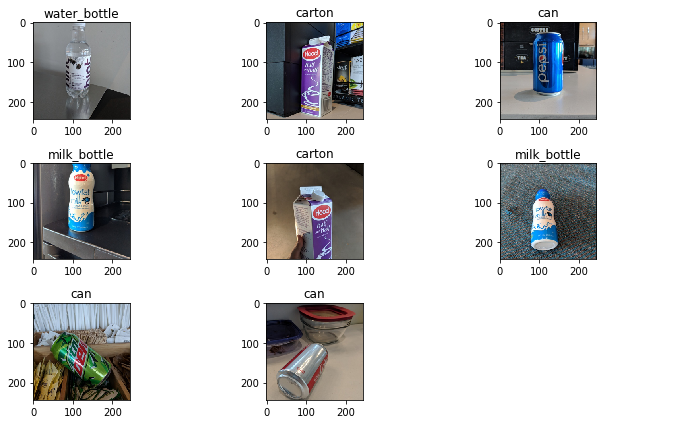

In [7]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False) 

In [40]:
## Creating the model
learn = cnn_learner(data, ARCHITECTURE, pretrained=True, metrics=accuracy)

In [70]:
#learn.model = nn.Sequential(*list(children(learn.model))[:][:-])
#learn.model

In [58]:
resnet50 = models.resnet50(pretrained=True)
# Chop-off last FC layer
print(list(resnet50.children())[-1])
chopped_resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])
chopped_resnet50.cuda()
learn.model = chopped_resnet50
learn.model

Linear(in_features=2048, out_features=1000, bias=True)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [59]:
preds,y = learn.get_preds(ds_type=DatasetType.Train)

In [60]:
print(preds.shape)
print(y)

torch.Size([128, 2048, 2, 2])
tensor([3, 2, 0, 0, 3, 2, 2, 3, 2, 1, 0, 1, 0, 0, 2, 2, 0, 0, 0, 3, 3, 3, 3, 2,
        2, 1, 0, 1, 0, 0, 0, 1, 3, 0, 2, 2, 3, 2, 3, 2, 3, 1, 3, 0, 0, 2, 1, 1,
        3, 2, 3, 3, 2, 2, 3, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 3, 3,
        2, 1, 3, 3, 1, 0, 0, 1, 3, 1, 0, 0, 2, 2, 3, 1, 3, 2, 0, 2, 3, 0, 2, 0,
        2, 1, 3, 0, 3, 1, 3, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 2, 2, 3, 0, 2, 3,
        3, 0, 1, 2, 3, 3, 2, 2])


In [69]:
shapes = list(preds.shape[1:])
preds_down = preds.view(-1, np.prod(shapes))
print(preds_down.shape)

torch.Size([128, 8192])


In [28]:
resnet50 = models.resnet50(pretrained=True)
# Chop-off last FC layer
print(list(resnet50.children())[-1])
chopped_resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])

Linear(in_features=2048, out_features=1000, bias=True)


In [29]:
chopped_resnet50

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [ ]:
## Fitting 5 epochs
learn.fit_one_cycle(5,1e-2)

In [ ]:
## Saving stage 1
learn.save('stg1-rn34')

In [ ]:
## Unfreeing layer and finding ideal learning rate
learn.unfreeze()


In [ ]:
## Fitting 5 epochs
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

In [ ]:
## Saving model weights
learn.save('stg2-rn34')

In [ ]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

In [ ]:
## By running this feature vectors would be saved in sf variable initated above
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [ ]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path, sf.features))
print(len(feature_dict))
#print(feature_dict)

In [ ]:
im1 = Path(DATA_PATH, "carton", "im_87.jpg")
feat1 = feature_dict[str(im1)]
print(feat1.shape)
im2 = Path(DATA_PATH, "carton", "im_86.jpg")
feat2 = feature_dict[str(im2)]
print(feat2.shape)
im3 = Path(DATA_PATH, "can", "im_44.jpg")
feat3 = feature_dict[str(im3)]
print(feat3.shape)

In [ ]:
print(compute_vector_distance(feat1, feat2, "l2"))
print(compute_vector_distance(feat1, feat3, "l2"))
